In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('NFA_2018_Edition.csv', sep = ',')

data.sample(5)

,country,year,country_code,record,crop_land,grazing_land,forest_land,fishing_ground,built_up_land,carbon,total,QScore
13379,Costa Rica,1987,48,BiocapTotGHA,1.425918e+06,2.316724e+06,2.883242e+06,579558.441600,226120.959700,0.000000,7.431563e+06,3A
17840,El Salvador,1985,60,AreaPerCap,1.220775e-01,1.557155e-01,8.025970e-02,0.372795,0.020475,0.000000,7.513235e-01,3A
16119,Dominica,2008,55,EFProdTotGHA,NaN,NaN,NaN,NaN,NaN,NaN,9.388040e+04,2B
8004,Myanmar,1983,28,EFConsPerCap,4.001270e-01,8.610456e-03,2.247410e-01,0.024042,0.046194,0.057164,7.608790e-01,3A
17990,El Salvador,2003,60,EFProdPerCap,2.567199e-01,1.537483e-01,3.585331e-01,0.064788,0.043321,0.367699,1.244810e+00,3A


In [ ]:
cleanData = data.dropna(axis=0, thresh=7)
print(cleanData.isna().sum())

country           0
year              0
country_code      0
record            0
crop_land         0
grazing_land      0
forest_land       0
fishing_ground    0
built_up_land     0
carbon            0
total             0
QScore            0
dtype: int64


In [ ]:
# data = data.drop([data.columns[QScore], data.columns[13]], axis=1)

modelData = cleanData[['year', 'country', 'country_code', 'record', 'crop_land', 'grazing_land', 'forest_land', 'fishing_ground', 'built_up_land', 'carbon', 'total']]
# modelData['year'] = pd.to_datetime(modelData['year'], format='%Y')
# modelData = modelData.groupby('record')
# EF = modelData.get_group('EFConsTotGHA')
EF = modelData.loc[modelData['record'] == "EFConsTotGHA"]
BC = modelData.loc[modelData['record'] == "BiocapTotGHA"]

EF = EF.drop(columns=['record', 'country', 'total'], axis=1) #include total?

# modelData.head(5)
EF.head(5)
# print(test.shape)
# print(EF.dtypes)

,year,country_code,crop_land,grazing_land,forest_land,fishing_ground,built_up_land,carbon
5,1992,1,1348487.313,6.524291e+05,4.327841,14272.803690,116139.5982,3836620.482
13,1993,1,1302751.210,6.764587e+05,36.034083,12858.191160,107720.2388,1803706.047
21,1994,1,1465650.720,1.044384e+06,76.861362,12389.700890,103552.5070,1045113.056
29,1995,1,1225971.655,6.324350e+05,54.385847,12654.898940,101521.3116,1341419.248
37,1996,1,1401538.065,7.083242e+05,70.623342,9615.560349,112371.3847,1062101.600


In [ ]:
EF.loc[:,'carbonLastYear'] = EF.loc[:,'carbon'].shift()

EF.loc[:,'carbonLastYear_Diff'] = EF.loc[:,'carbonLastYear'].diff()
EF = EF.dropna()

EF['carbon2Years'] = EF['carbonLastYear'].shift()

EF['carbon2Years_Diff'] = EF['carbon2Years'].diff()

EF = EF.dropna()
EF.head(15)

,year,country_code,crop_land,grazing_land,forest_land,fishing_ground,built_up_land,carbon,carbonLastYear,carbonLastYear_Diff,carbon2Years,carbon2Years_Diff
37,1996,1,1401538.065,708324.2224,70.623342,9615.560349,112371.38470,1062101.600,1341419.248,296306.192,1045113.056,-758592.991
45,1997,1,1252058.972,810575.7136,29595.696130,10846.558920,89286.04608,1285325.937,1062101.600,-279317.648,1341419.248,296306.192
53,1998,1,1443882.421,668051.8320,6424.069023,14859.152820,111575.11510,1346444.523,1285325.937,223224.337,1062101.600,-279317.648
61,1999,1,1181533.256,618857.7347,7130.826522,20483.664950,107416.22260,1611430.089,1346444.523,61118.586,1285325.937,223224.337
69,2000,1,1259829.829,614842.2641,44356.729720,27022.891050,91050.15164,1482757.150,1611430.089,264985.566,1346444.523,61118.586
77,2001,1,1328215.733,618067.4233,118700.480700,25569.157370,119014.41380,1535548.327,1482757.150,-128672.939,1611430.089,264985.566
85,2002,1,1436799.874,653870.9060,66851.079760,29871.620720,126593.04490,1449511.435,1535548.327,52791.177,1482757.150,-128672.939
93,2003,1,1307967.318,694975.0832,82025.776330,25475.087680,111268.62070,1626392.048,1449511.435,-86036.892,1535548.327,52791.177
101,2004,1,1607245.130,722762.1857,115050.665200,32724.381990,142071.08430,1747333.287,1626392.048,176880.613,1449511.435,-86036.892
109,2005,1,1670779.000,706841.8118,106050.229500,67476.947820,158755.15180,2061492.216,1747333.287,120941.239,1626392.048,176880.613


In [ ]:
# EF = EF.set_index('year')
array = [i for i in range(1996, 2015)]
# train = EF.loc[EF['year'] != 2014]
train = EF.loc[EF['year'].isin(array)]
test = EF.loc[EF['year'] == 2014]

train['year'] = pd.to_datetime(train['year'], format='%Y')
test['year'] = pd.to_datetime(test['year'], format='%Y')

train = train.set_index('year') #set date as index
test = test.set_index('year') #set date as index - needed for models to work

X_train = train.drop(['carbon'], axis = 1)
y_train = train['carbon']

X_test = test.drop(['carbon'], axis = 1)
y_test = test['carbon']




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


KNN: 0.833240 (0.183631)
RF: 0.646453 (0.717099)


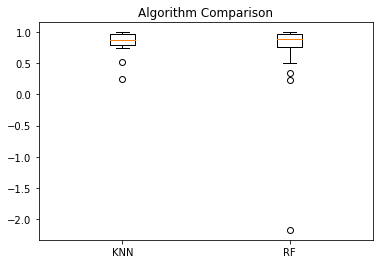

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

models = []
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 18)))

results = []
names = []
for name, model in models:
  tscv = TimeSeriesSplit(n_splits=18)
  cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
  results.append(cv_results)
  names.append(name)
  print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [ ]:
# # from sklearn import preprocessing
# from sklearn.preprocessing import MinMaxScaler
# # X_train = preprocessing.scale(X_train) 
# # y_train = preprocessing.scale(y_train)

# scaler = MinMaxScaler(copy = True, feature_range = (0, 1))
# # X_train = scaler.fit_transform(X_train)
# X_train = preprocessing.scale(X_train) 
# y_train = preprocessing.scale(y_train)


In [ ]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    # 'n_estimators': [36, 90, 180],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=18)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [ ]:
y_true = y_test.values
y_pred = best_model.predict(X_test)

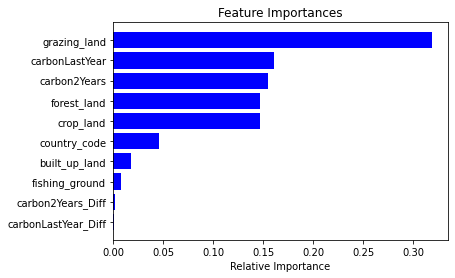

In [ ]:
import numpy as np

imp = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(imp)

plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
X_train = X_train.drop(['carbonLastYear_Diff', 'carbon2Years_Diff', 'fishing_ground', 'built_up_land'], axis = 1)
X_test = X_test.drop(['carbonLastYear_Diff', 'carbon2Years_Diff', 'fishing_ground', 'built_up_land'], axis = 1)

KNN: 0.835500 (0.183156)
RF: 0.638018 (0.868890)


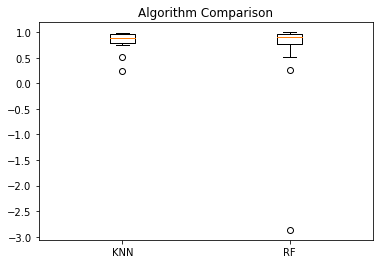

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

models = []
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 18)))

results = []
names = []
for name, model in models:
  tscv = TimeSeriesSplit(n_splits=18)
  cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
  results.append(cv_results)
  names.append(name)
  print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

# RF = RandomForestRegressor(n_estimators = 18)
KNN = KNeighborsRegressor()

# y_true = y_test.values
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)

print("Evaluation metrics of KNN: ", KNN.score(X_test, y_test))

# confusion_matrix(y_pred, y_test) #No confusion matirx since output continous

Evaluation metrics of KNN:  0.9985333792685952


In [ ]:
# from sklearn import metrics
# import matplotlib.pyplot as plt

# metrics.plot_roc_curve(KNN, X_test, y_test)
# # metrics.plot_roc_curve(clf, features_test, labels_test)

# plt.show()